# Linear Model tests for GCSI using coderdata
The goal is to evaluate the capability to predict drug responese AUC values of several linear models using the `coderdata` infrastructure for dataset generation.

## Imports & Dependecies

In [190]:
# iPython magic to autoreload modules everytime code is executed to propagate changes to the code
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [191]:
from copy import deepcopy
import logging
import os
from pathlib import Path

import coderdata as cd
import numpy as np

from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

import sklearn.linear_model as LM
from sklearn import metrics
from sklearn import svm

The cell below sets up a "magic" function to skip the execution of a cell when rendering the notebook.

In [192]:
from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell):
    return

We also setup a logger for logging the progress.

In [193]:
logger = logging.getLogger('linear_models_logger')
loglevel = logging.INFO # change to logging.DEBUG for increased verbosity
logging.basicConfig(
    format="{asctime} - {levelname} - {message}",
    style="{",
    datefmt="%Y-%m-%d %H:%M",
    level=loglevel
    )

## Data import
We use `coderdata` to download and import drug response data as well as cancer metadata from the BeatAML study.

First we generate a temporary folder (if it does not exist yet) and change into this directory.

In [194]:
local_path = Path('/tmp/coderdata_lin_mod_test')
if not local_path.exists() or not local_path.is_dir():
    local_path.mkdir(parents=True)
os.chdir(local_path)

Defining the dataset that we want to use (GCSI)

In [195]:
dataset_name = 'gdscv2'

Once the data for GCSI has be retrieved by the cell below and is available locally, we can uncomment the `%%skip` command such that the cell below is skipped in consecutive executions of the notebook. 

In [196]:
%%skip
cd.download(
    name=dataset_name,
    local_path=local_path,
    exist_ok=True
    )

In [197]:
data = cd.load(
    name=dataset_name,
    local_path=local_path
    )

Importing raw data ...
Importing 'transcriptomics' from /tmp/coderdata_lin_mod_test/gdscv2_transcriptomics.csv.gz ... DONE
Importing 'mutations' from /tmp/coderdata_lin_mod_test/gdscv2_mutations.csv.gz ... DONE
Importing 'copy_number' from /tmp/coderdata_lin_mod_test/gdscv2_copy_number.csv.gz ... DONE
Importing 'samples' from /tmp/coderdata_lin_mod_test/gdscv2_samples.csv ... DONE
Importing 'drugs' from /tmp/coderdata_lin_mod_test/gdscv2_drugs.tsv.gz ... DONE
Importing 'proteomics' from /tmp/coderdata_lin_mod_test/gdscv2_proteomics.csv.gz ... DONE
Importing 'genes' from /tmp/coderdata_lin_mod_test/genes.csv.gz ... DONE
Importing 'experiments' from /tmp/coderdata_lin_mod_test/gdscv2_experiments.tsv.gz ... DONE
Importing 'drug_descriptors' from /tmp/coderdata_lin_mod_test/gdscv2_drug_descriptors.tsv.gz ... DONE
Importing raw data ... DONE


In [199]:
drug_response = data.format('experiments', shape='wide', metrics=['auc']).dropna()

In [200]:
drug_response.groupby("improve_drug_id").count()

,source,improve_sample_id,study,time,time_unit,auc
improve_drug_id,,,,,,
SMI_10143,727,727,727,727,727,727
SMI_10333,749,749,749,749,749,749
SMI_10376,798,798,798,798,798,798
SMI_10484,749,749,749,749,749,749
SMI_11007,727,727,727,727,727,727
...,...,...,...,...,...,...
SMI_8051,749,749,749,749,749,749
SMI_8098,727,727,727,727,727,727
SMI_8294,49,49,49,49,49,49


In [201]:
drug_counts = drug_response.groupby("improve_drug_id").count()
select_drugs = drug_counts[drug_counts['improve_sample_id']>=750].reset_index()
data_for_plot = drug_response[drug_response['improve_drug_id'].isin(select_drugs['improve_drug_id'])]
# data_for_plot = drug_response[drug_response['improve_drug_id'].isin(['SMI_46210'])]

In [202]:
data_for_plot

,source,improve_sample_id,improve_drug_id,study,time,time_unit,auc
2,pharmacoGX,11.0,SMI_10376,GDSCv2,72,hours,0.9713
5,pharmacoGX,11.0,SMI_11391,GDSCv2,72,hours,0.9820
6,pharmacoGX,11.0,SMI_11502,GDSCv2,72,hours,0.9511
7,pharmacoGX,11.0,SMI_11831,GDSCv2,72,hours,0.7694
9,pharmacoGX,11.0,SMI_12635,GDSCv2,72,hours,0.9711
...,...,...,...,...,...,...,...
113921,pharmacoGX,1924.0,SMI_55473,GDSCv2,72,hours,0.5748
113928,pharmacoGX,1924.0,SMI_55653,GDSCv2,72,hours,0.8643
113947,pharmacoGX,1924.0,SMI_55689,GDSCv2,72,hours,0.9456
113958,pharmacoGX,1924.0,SMI_659,GDSCv2,72,hours,0.7537


In [203]:
grouping = data_for_plot.groupby('improve_drug_id')
ordering = grouping.count().sort_values(by='improve_sample_id', ascending=False).index

(-0.05, 1.05)

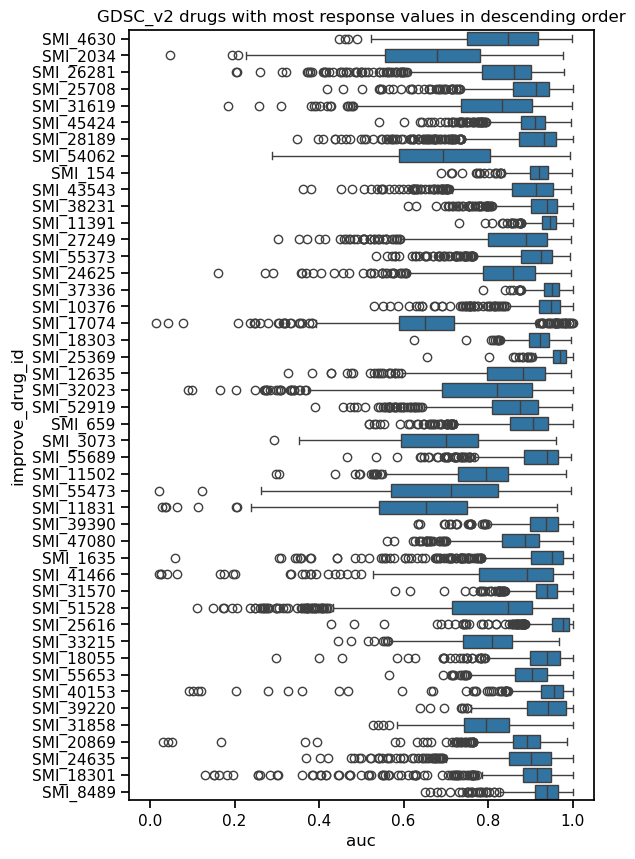

In [204]:
fig, ax = plt.subplots(figsize=(6,10))

sns.set_context('notebook')
plot = (
    sns.boxplot(
        data=data_for_plot,
        y='improve_drug_id',
        x='auc',
        order=ordering,
        ax=ax
    )
)
ax.set_title("GDSC_v2 drugs with most response values in descending order")
ax.set_xlim(-0.05, 1.05)

Based on the plot intersting drugs could be:
- SMI_2034 <-> docetaxel
- SMI_54062 <-> luminespib
- SMI_17074 <-> actinomycin D / cosmegen
- SMI_55473 <-> gemcitabine
- SMI_39220 <-> paclitaxel

In [205]:
data.drugs[data.drugs['chem_name'].str.contains('selum')]

,improve_drug_id,chem_name,pubchem_id,canSMILES,InChIKey,formula,weight
8793,SMI_46210,selumetinib [usan],10127622,CN1C=NC2=C1C=C(C(=C2F)NC3=C(C=C(C=C3)Br)Cl)C(=...,CYOHGALHFOKKQC-UHFFFAOYSA-N,C17H15BrClFN4O3,457.7
8794,SMI_46210,selumetinib (arry142886/azd6244),10127622,CN1C=NC2=C1C=C(C(=C2F)NC3=C(C=C(C=C3)Br)Cl)C(=...,CYOHGALHFOKKQC-UHFFFAOYSA-N,C17H15BrClFN4O3,457.7
8796,SMI_46210,selumetinib [who-dd],10127622,CN1C=NC2=C1C=C(C(=C2F)NC3=C(C=C(C=C3)Br)Cl)C(=...,CYOHGALHFOKKQC-UHFFFAOYSA-N,C17H15BrClFN4O3,457.7
8807,SMI_46210,selumetinib [inn],10127622,CN1C=NC2=C1C=C(C(=C2F)NC3=C(C=C(C=C3)Br)Cl)C(=...,CYOHGALHFOKKQC-UHFFFAOYSA-N,C17H15BrClFN4O3,457.7
8809,SMI_46210,selumetinib [usan:inn],10127622,CN1C=NC2=C1C=C(C(=C2F)NC3=C(C=C(C=C3)Br)Cl)C(=...,CYOHGALHFOKKQC-UHFFFAOYSA-N,C17H15BrClFN4O3,457.7
8812,SMI_46210,selumetinibum,10127622,CN1C=NC2=C1C=C(C(=C2F)NC3=C(C=C(C=C3)Br)Cl)C(=...,CYOHGALHFOKKQC-UHFFFAOYSA-N,C17H15BrClFN4O3,457.7
8823,SMI_46210,selumetinib (azd6244),10127622,CN1C=NC2=C1C=C(C(=C2F)NC3=C(C=C(C=C3)Br)Cl)C(=...,CYOHGALHFOKKQC-UHFFFAOYSA-N,C17H15BrClFN4O3,457.7
8828,SMI_46210,"azd6244 (selumetinib,arry-142886)?",10127622,CN1C=NC2=C1C=C(C(=C2F)NC3=C(C=C(C=C3)Br)Cl)C(=...,CYOHGALHFOKKQC-UHFFFAOYSA-N,C17H15BrClFN4O3,457.7
8840,SMI_46210,"azd6244,selumetinib, arry-142886",10127622,CN1C=NC2=C1C=C(C(=C2F)NC3=C(C=C(C=C3)Br)Cl)C(=...,CYOHGALHFOKKQC-UHFFFAOYSA-N,C17H15BrClFN4O3,457.7
8843,SMI_46210,selumetinib,10127622,CN1C=NC2=C1C=C(C(=C2F)NC3=C(C=C(C=C3)Br)Cl)C(=...,CYOHGALHFOKKQC-UHFFFAOYSA-N,C17H15BrClFN4O3,457.7


Next we can take a look at the drugs which are used in the cancer dataset we selected.

In [206]:
data.drugs[data.drugs['improve_drug_id'].isin(data.experiments['improve_drug_id'].unique())]

,improve_drug_id,chem_name,pubchem_id,canSMILES,InChIKey,formula,weight
0,SMI_129,"(3ar-(3aalpha,4beta,5beta,5abeta,9(3r*,5s*,7r*...",13342,CCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(...,JXLYSJRDGCGARV-CFWMRBGOSA-N,C46H58N4O9,811.00
1,SMI_129,vr-8,13342,CCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(...,JXLYSJRDGCGARV-CFWMRBGOSA-N,C46H58N4O9,811.00
2,SMI_129,nci-c04842,13342,CCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(...,JXLYSJRDGCGARV-CFWMRBGOSA-N,C46H58N4O9,811.00
3,SMI_129,nincaluicolflastine,13342,CCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(...,JXLYSJRDGCGARV-CFWMRBGOSA-N,C46H58N4O9,811.00
4,SMI_129,chembl159,13342,CCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(...,JXLYSJRDGCGARV-CFWMRBGOSA-N,C46H58N4O9,811.00
...,...,...,...,...,...,...,...
13585,SMI_50270,akos024464752,46239015,CN1C=C(C=N1)C2=C3N=C(C(=C(N3N=C2)N)Br)C4CCCNC4,GMIZZEXBPRLVIV-SECBINFHSA-N,C15H18BrN7,376.25
13586,SMI_50270,k2zsf0992c,46239015,CN1C=C(C=N1)C2=C3N=C(C(=C(N3N=C2)N)Br)C4CCCNC4,GMIZZEXBPRLVIV-SECBINFHSA-N,C15H18BrN7,376.25
13587,SMI_50270,mk-8776 dihydrochloride,46239015,CN1C=C(C=N1)C2=C3N=C(C(=C(N3N=C2)N)Br)C4CCCNC4,GMIZZEXBPRLVIV-SECBINFHSA-N,C15H18BrN7,376.25
13588,SMI_50270,brd-k75009076-001-02-1,46239015,CN1C=C(C=N1)C2=C3N=C(C(=C(N3N=C2)N)Br)C4CCCNC4,GMIZZEXBPRLVIV-SECBINFHSA-N,C15H18BrN7,376.25


To make sure that we only be using data that is related to the selected drug we further need to subset the training / testing (and validation) data.

In [207]:
def filter_by_drugid(data, drug_id):
    data_ret = deepcopy(data)
    
    data_ret.experiments = data_ret.experiments[
        data_ret.experiments['improve_drug_id'] == drug_id
        ]
    data_ret.drugs = data_ret.drugs[
        data_ret.drugs['improve_drug_id'] == drug_id
        ]
    
    sample_ids = data_ret.experiments['improve_sample_id'].unique()

    data_ret.mutations = data_ret.mutations[
        data_ret.mutations['improve_sample_id'].isin(sample_ids)
        ]
    data_ret.proteomics = data_ret.proteomics[
        data_ret.proteomics['improve_sample_id'].isin(sample_ids)
        ]
    data_ret.samples = data_ret.samples[
        data_ret.samples['improve_sample_id'].isin(sample_ids)
        ]
    data_ret.transcriptomics = data_ret.transcriptomics[
        data_ret.transcriptomics['improve_sample_id'].isin(sample_ids)
        ]
    
    return data_ret

Next we can generate the training, testing (and validation) splits. We are also going to define the arguments for the `coderdata` splitting function:

In [208]:
def generate_model_input_matrices(
        data: cd.Dataset,
        split: cd.Dataset,
        features:list,
        response_metric: str
        ) -> np.ndarray:
    
    
    d_response = data.format(
        data_type='experiments',
        shape='wide',
        metrics=response_metric
        )
    if len(features) == 1:
        d_feature_tmp = data.format(
            data_type=features[0],
            ).reset_index()
    else:
        feature = features[0]
        if feature in ['transcriptomics', 'proteomics']:
            d_feature_tmp = data.format(
                data_type=feature,
                ).reset_index()
        elif feature == 'mutations':
            d_feature_tmp = data.format(
                data_type=feature, mutation_type='Misssense_Mutation',
                ).reset_index()
    # else:
    #     raise NotImplementedError("more than 1 feature type currently not implemented")
    
    improve_sample_ids = split.experiments['improve_sample_id']

    d_feature_tmp = d_feature_tmp[d_feature_tmp['improve_sample_id'].isin(improve_sample_ids)]
    y = d_response.loc[d_response['improve_sample_id'].isin(d_feature_tmp['improve_sample_id']), response_metric].to_numpy()
    x = d_feature_tmp.loc[:, d_feature_tmp.columns != 'improve_sample_id'].to_numpy(na_value=0)
    
    return x, y

In [209]:
en_model = LM.ElasticNet( 
    random_state=0,
    max_iter=100000, 
    fit_intercept=True,
    l1_ratio=.7,
    alpha=.9,
)

lasso_model = LM.Lasso(
    alpha=0.1,
    max_iter=100000, 
    fit_intercept=True,
)

svm_model = svm.SVR(C=1.0, epsilon=0.2, kernel='linear')
svc_model = svm.SVC(C=1.0, kernel='linear')

def run_sklearn(x_train, y_train, x_test, y_test, model, model_name, binarize=False):
        
    # don't think we need scaling? Can add in pretty quickly if we do
#     pipe = pipeline.Pipeline([
# #         ('scaler', preprocessing.StandardScaler()),
#         ('model', model)
#     ])
    if binarize:
        y_train, y_test = convert_to_binary(y_train, y_test)
    
    model.fit(x_train, y_train)
    train_pred = model.predict(x_train)
    preds = model.predict(x_test)
    error, r2, pearson = score_all(y_test, preds)
    coef = np.array(model.coef_).flatten()
    # feature_names = model.feature_names_in_[coef>0]
    auc = np.nan
    if binarize:
        auc = metrics.average_precision_score(y_test, preds)
    return {
        'test_prediction': preds,
        'train_prediction': train_pred,
        'pearsonr': pearsonr(y_test, preds)[0],
        'mse': error,
        'r2' : r2,
        'model': model_name,
        # 'feature_names': feature_names,
        'auc': auc
    }

def convert_to_binary(y_train, y_test):
    """ Binarize AUC """
    y_train_c = np.copy(y_train)
    y_test_c = np.copy(y_test)
    y_train_c[y_train_c<100] = 1
    y_train_c[y_train_c>100] = 0
    y_test_c[y_test_c<100] = 1
    y_test_c[y_test_c>100] = 0
    return y_train_c, y_test_c

def score_all(y_test, preds):
    error = np.sqrt(metrics.mean_squared_error(y_test, preds))
    r2 = metrics.r2_score(y_test, preds)
    pearson = pearsonr(y_test, preds)[0]
    print(f"RMSE: {error:0.3f} | R^2 {r2:0.3f} | R {pearson:0.3f}")
    return error, r2, pearson


In [210]:
# drug_name = 'docetaxel'
# drug_name = 'luminespib'
# drug_name = 'cosmegen'
drug_name = 'gemcitabine'
# drug_name = 'paclitaxel'
# drug_name = 'selumetinib'
drug_id = data.drugs.loc[data.drugs['chem_name'] == drug_name, 'improve_drug_id'].values[0]

In [ ]:
%%skip

split_type = 'mixed-set'
ratio = (8, 1, 1)
random_state = 42

data_filtered = filter_by_drugid(data, drug_id)
split_filtered = data_filtered.split_train_test_validate(
    split_type=split_type,
    ratio=ratio,
    stratify_by='fit_auc',
    balance=True,
    thresh=0.5,
    random_state=random_state
)
train_filtered = split_filtered.train
test_filtered = split_filtered.test
val_filtered = split_filtered.validate

In [253]:
# %%skip

split_type = 'mixed-set'
# split_type = 'cancer-blind'
ratio = (9, 1)
random_state = 42

data_filtered = filter_by_drugid(data, drug_id)
split_filtered = data_filtered.split_train_other(
    split_type=split_type,
    ratio=ratio,
    stratify_by='fit_auc',
    balance=True,
    thresh=0.5,
    random_state=random_state
)
train_filtered = split_filtered.train
test_filtered = split_filtered.other

In [258]:
response_metric = 'fit_auc'
feature = 'transcriptomics'


train_x, train_y = generate_model_input_matrices(
    data=data_filtered,
    split=train_filtered,
    features=[feature],
    response_metric=response_metric
    )

test_x, test_y = generate_model_input_matrices(
    data=data_filtered,
    split=test_filtered,
    features=[feature],
    response_metric=response_metric
    )

In [249]:

enet_results = run_sklearn(x_train=train_x, y_train=train_y, x_test=test_x, y_test=test_y, model=en_model, model_name='EN')
lasso_results = run_sklearn(x_train=train_x, y_train=train_y, x_test=test_x, y_test=test_y, model=lasso_model, model_name='LASSO')
svm_results = run_sklearn(x_train=train_x, y_train=train_y, x_test=test_x, y_test=test_y, model=svm_model, model_name='SVM')
# svc_results = run_sklearn(x_train=train_x, y_train=train_y, x_test=test_x, y_test=test_y, model=svc_model, model_name='SVC')

/var/folders/81/d9jch6jj21z6tg8dndtgpry00000gn/T/ipykernel_9722/4041944660.py:61: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson = pearsonr(y_test, preds)[0]
/var/folders/81/d9jch6jj21z6tg8dndtgpry00000gn/T/ipykernel_9722/4041944660.py:40: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  'pearsonr': pearsonr(y_test, preds)[0],
/var/folders/81/d9jch6jj21z6tg8dndtgpry00000gn/T/ipykernel_9722/4041944660.py:61: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  pearson = pearsonr(y_test, preds)[0]
/var/folders/81/d9jch6jj21z6tg8dndtgpry00000gn/T/ipykernel_9722/4041944660.py:40: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  'pearsonr': pearsonr(y_test, preds)[0],


RMSE: 0.170 | R^2 -0.003 | R nan
RMSE: 0.170 | R^2 -0.003 | R nan
RMSE: 0.142 | R^2 0.294 | R 0.651


RMSE: 0.159 | R^2 0.115 | R 0.651


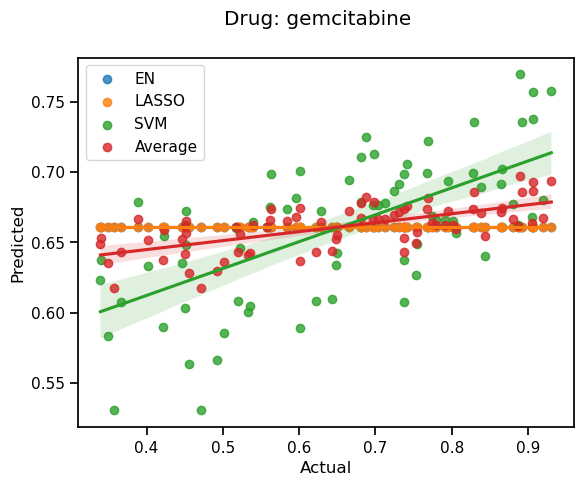

In [239]:
avg = np.zeros(len(enet_results['test_prediction']))
for i in [
    # gbt_results,
    enet_results, lasso_results, svm_results,
    # svc_results
    ]:
    sns.regplot(x=test_y, y=i['test_prediction'], label=i['model'])
    avg += i['test_prediction']
avg = avg/3
score_all(test_y, avg)
sns.regplot(x=test_y, y=avg, label='Average')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()
plt.suptitle(f"Drug: {drug_name}")
results = pd.DataFrame(
    [
        # gbt_results, gbt_binary_results,
        enet_results, lasso_results, svm_results,
        # svc_results
        ]
)